<a href="https://colab.research.google.com/github/kahunahana/MGMT-5900-_Capstone_Brainiacs-6/blob/main/theLook_Kmeans_model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Begin by loading necessary packages




In [1]:
!pip install -q google-cloud-bigquery
import os
from google.cloud import bigquery

from google.colab import auth
auth.authenticate_user()

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

### Load the dataset from bigquery

In [2]:
project_id = 'thelook-product-recom-1'
client = bigquery.Client(project=project_id)


In [3]:
query = """
SELECT *
FROM `thelook-product-recom-1.theLook.customer_features`
"""

# Run the query and load the result into a Pandas DataFrame
df = client.query(query).to_dataframe()


### Conduct EDA

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,100000.0,50000.5,28867.657797,1.0,25000.75,50000.5,75000.25,100000.0
age,100000.0,40.99358,16.978825,12.0,26.0,41.0,56.0,70.0
lifetime_total_value,100000.0,108.07653,134.963693,0.0,16.25,62.0,151.932502,1604.849998
total_order_count,100000.0,1.25281,0.994589,0.0,1.0,1.0,2.0,4.0
average_order_value,100000.0,69.086421,81.538423,0.0,15.72,48.0,94.950001,1303.019999


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               100000 non-null  Int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  Int64  
 3   country               100000 non-null  object 
 4   traffic_source        100000 non-null  object 
 5   lifetime_total_value  100000 non-null  float64
 6   total_order_count     100000 non-null  Int64  
 7   average_order_value   100000 non-null  float64
 8   favorite_category     80127 non-null   object 
 9   favorite_browser      80159 non-null   object 
dtypes: Int64(3), float64(2), object(5)
memory usage: 7.9+ MB


<Axes: >

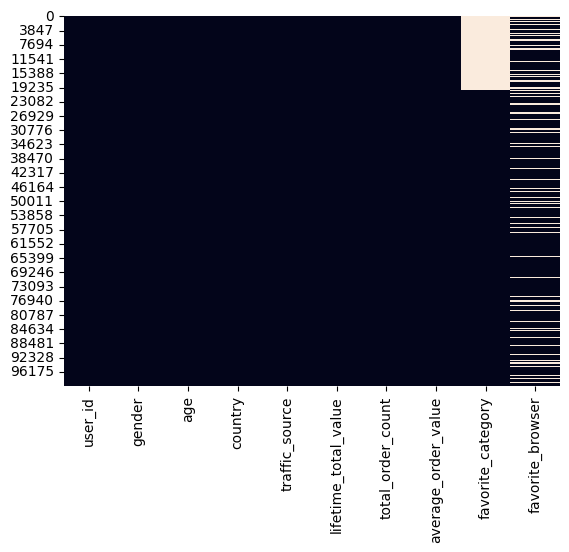

In [6]:
# check for missin values

sns.heatmap(df.isnull(), cbar=False)


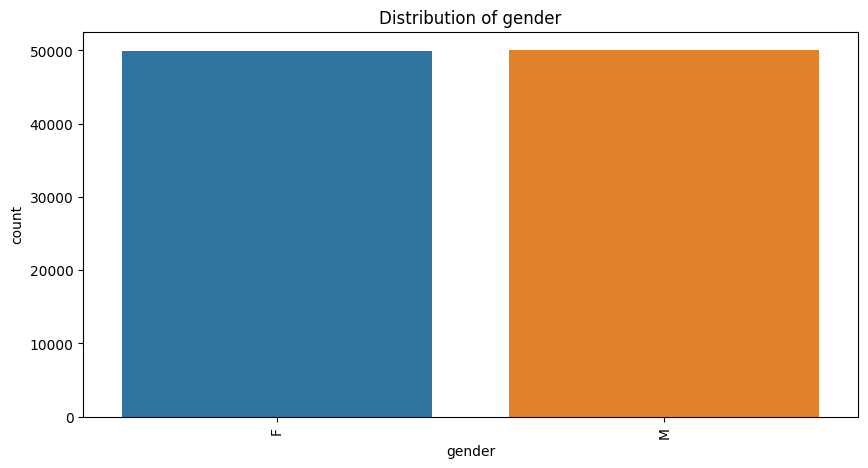

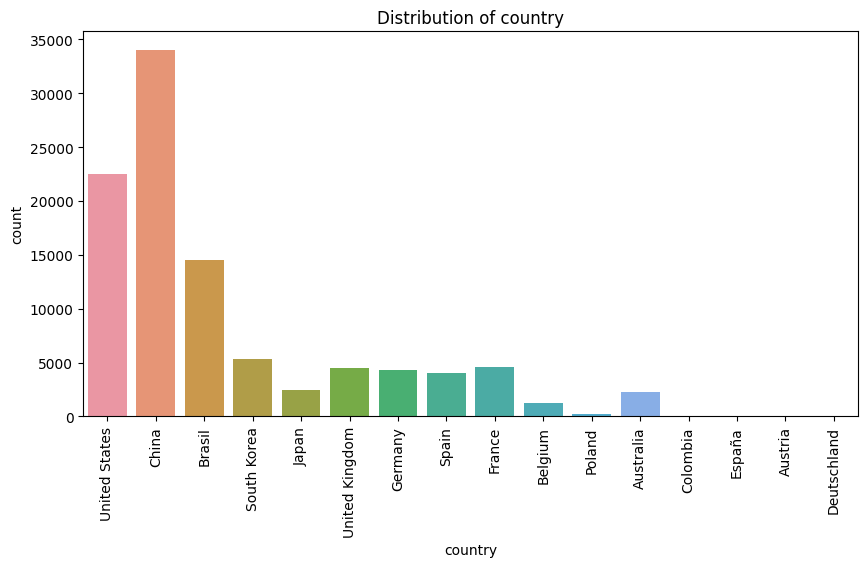

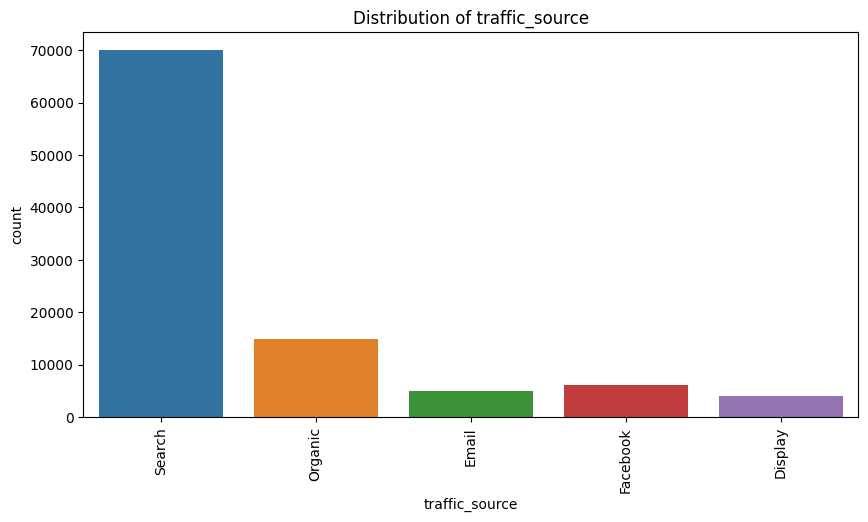

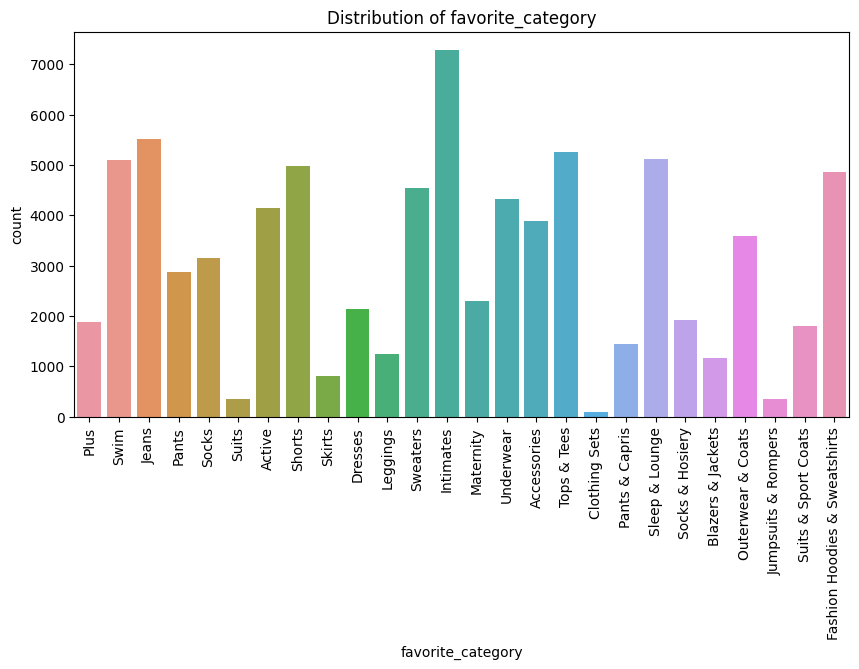

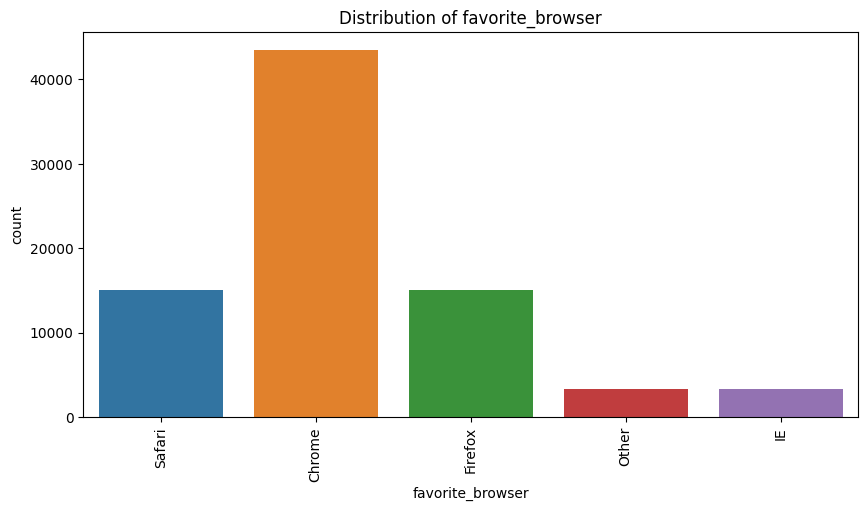

In [7]:
# distribution of categorical features

categorical_features = ['gender', 'country', 'traffic_source', 'favorite_category', 'favorite_browser']

for feature in categorical_features:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=90)
    plt.show()


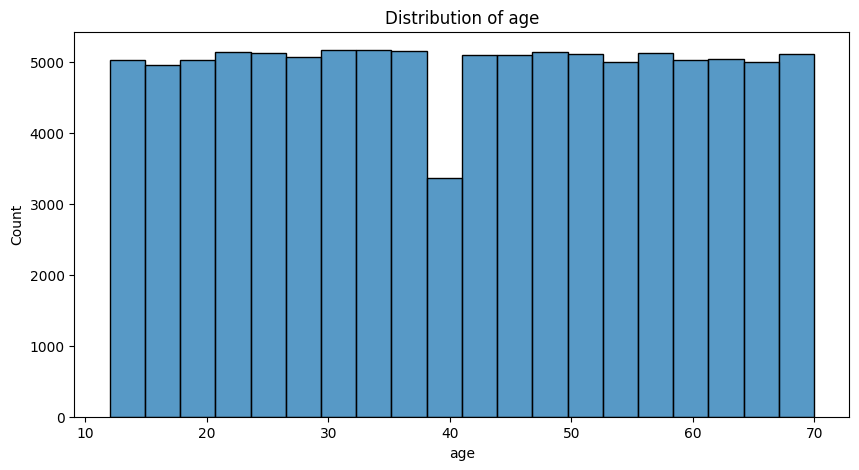

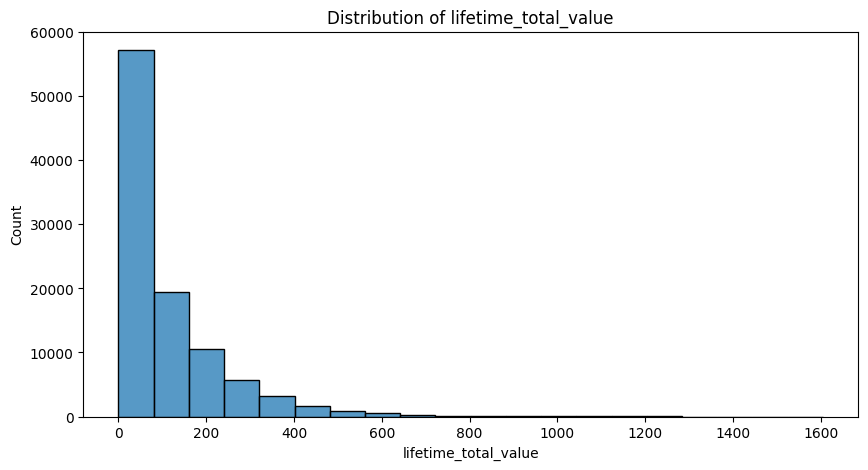

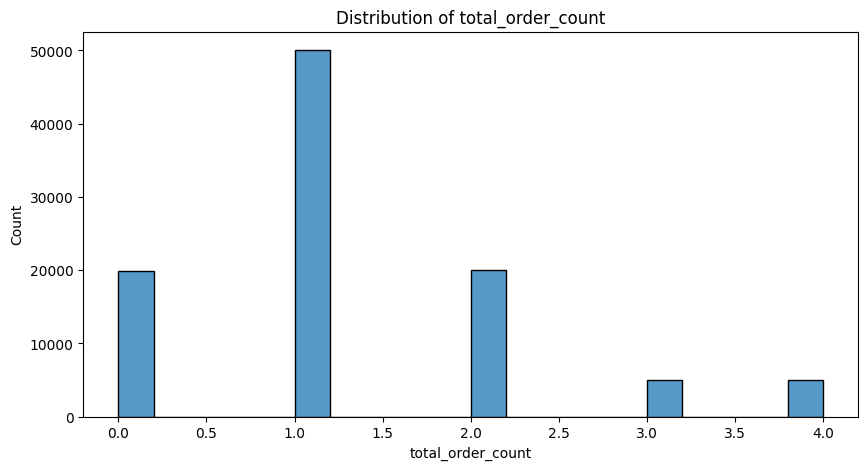

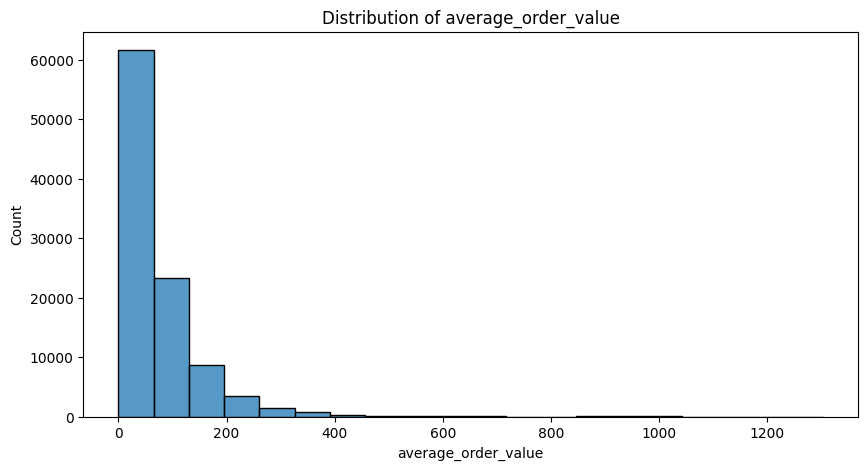

In [8]:
# examine numerical features
numerical_features = ['age', 'lifetime_total_value', 'total_order_count', 'average_order_value']

for feature in numerical_features:
    plt.figure(figsize=(10,5))
    sns.histplot(data=df, x=feature, bins=20)
    plt.title(f'Distribution of {feature}')
    plt.show()


<Axes: >

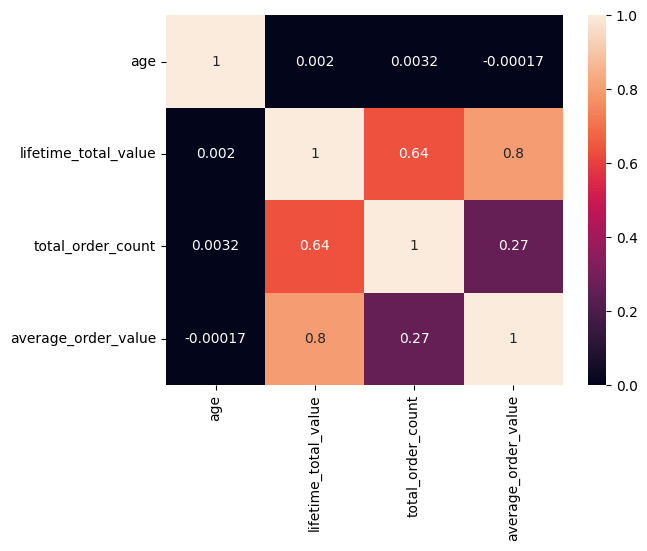

In [9]:
# correlation matrix

correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True)


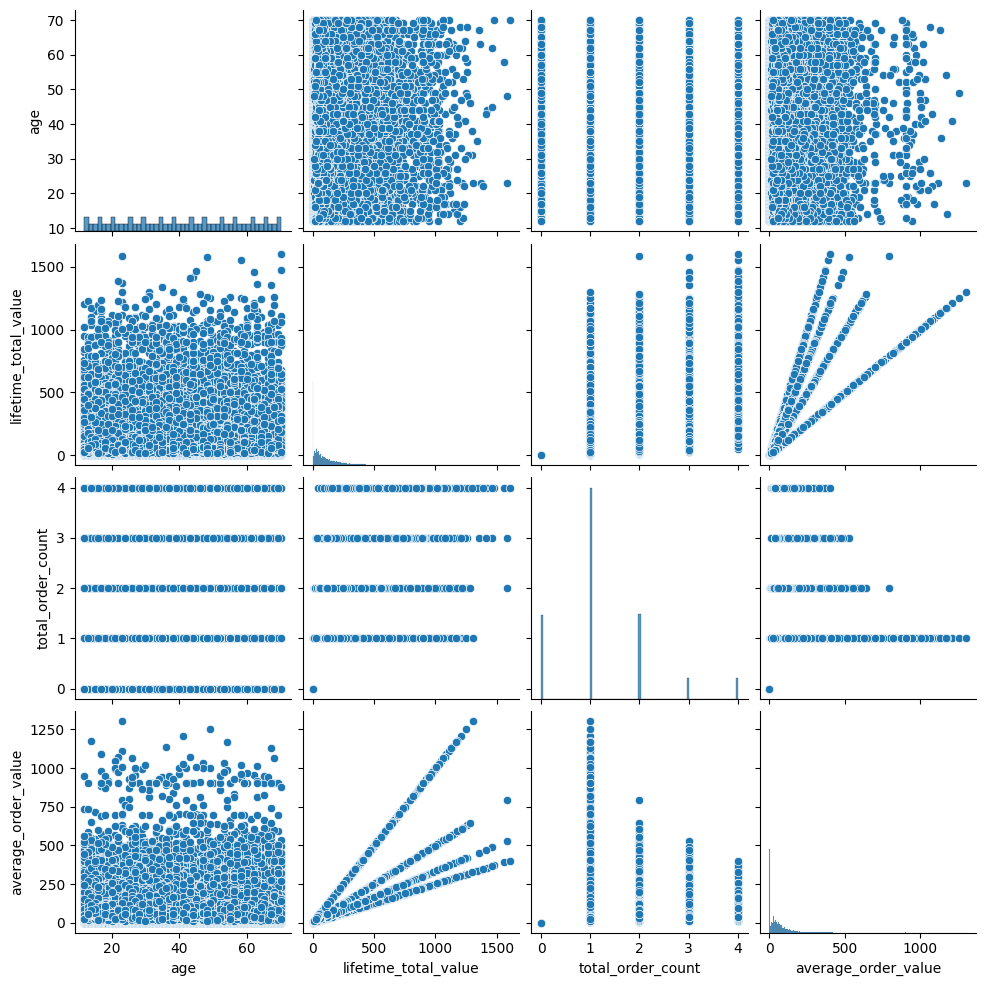

In [10]:
sns.pairplot(df[numerical_features])


### Replace Missing Values

In [11]:
df['favorite_browser'].fillna('unknown', inplace=True)
df['favorite_category'].fillna('unknown', inplace=True)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               100000 non-null  Int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  Int64  
 3   country               100000 non-null  object 
 4   traffic_source        100000 non-null  object 
 5   lifetime_total_value  100000 non-null  float64
 6   total_order_count     100000 non-null  Int64  
 7   average_order_value   100000 non-null  float64
 8   favorite_category     100000 non-null  object 
 9   favorite_browser      100000 non-null  object 
dtypes: Int64(3), float64(2), object(5)
memory usage: 7.9+ MB


### Data Preprocessing for Kmeans Model

In [13]:
# one hot encode the categorical values
df = pd.get_dummies(df, columns=['gender', 'country', 'traffic_source', 'favorite_category', 'favorite_browser'])


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 61 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   user_id                                          100000 non-null  Int64  
 1   age                                              100000 non-null  Int64  
 2   lifetime_total_value                             100000 non-null  float64
 3   total_order_count                                100000 non-null  Int64  
 4   average_order_value                              100000 non-null  float64
 5   gender_F                                         100000 non-null  uint8  
 6   gender_M                                         100000 non-null  uint8  
 7   country_Australia                                100000 non-null  uint8  
 8   country_Austria                                  100000 non-null  uint8  
 9   country_Belgium 

In [15]:
# fix column names

# Replace spaces and ampersands with underscores in column names
df.columns = df.columns.str.replace(' & ', '_').str.replace(' ', '_')

# Verify the new column names
print(df.columns)


Index(['user_id', 'age', 'lifetime_total_value', 'total_order_count',
       'average_order_value', 'gender_F', 'gender_M', 'country_Australia',
       'country_Austria', 'country_Belgium', 'country_Brasil', 'country_China',
       'country_Colombia', 'country_Deutschland', 'country_España',
       'country_France', 'country_Germany', 'country_Japan', 'country_Poland',
       'country_South_Korea', 'country_Spain', 'country_United_Kingdom',
       'country_United_States', 'traffic_source_Display',
       'traffic_source_Email', 'traffic_source_Facebook',
       'traffic_source_Organic', 'traffic_source_Search',
       'favorite_category_Accessories', 'favorite_category_Active',
       'favorite_category_Blazers_Jackets', 'favorite_category_Clothing_Sets',
       'favorite_category_Dresses',
       'favorite_category_Fashion_Hoodies_Sweatshirts',
       'favorite_category_Intimates', 'favorite_category_Jeans',
       'favorite_category_Jumpsuits_Rompers', 'favorite_category_Leggings',
 

In [16]:
# Replace the specific column name with only alphanumeric characters
df.rename(columns={'country_España': 'country_Espana'}, inplace=True)

# Verify the new column names
print(df.columns)


Index(['user_id', 'age', 'lifetime_total_value', 'total_order_count',
       'average_order_value', 'gender_F', 'gender_M', 'country_Australia',
       'country_Austria', 'country_Belgium', 'country_Brasil', 'country_China',
       'country_Colombia', 'country_Deutschland', 'country_Espana',
       'country_France', 'country_Germany', 'country_Japan', 'country_Poland',
       'country_South_Korea', 'country_Spain', 'country_United_Kingdom',
       'country_United_States', 'traffic_source_Display',
       'traffic_source_Email', 'traffic_source_Facebook',
       'traffic_source_Organic', 'traffic_source_Search',
       'favorite_category_Accessories', 'favorite_category_Active',
       'favorite_category_Blazers_Jackets', 'favorite_category_Clothing_Sets',
       'favorite_category_Dresses',
       'favorite_category_Fashion_Hoodies_Sweatshirts',
       'favorite_category_Intimates', 'favorite_category_Jeans',
       'favorite_category_Jumpsuits_Rompers', 'favorite_category_Leggings',
 

In [17]:
# save a copy of the dataframe

df_elbow = df.copy()

### Scale data

In [18]:
from sklearn.preprocessing import StandardScaler

# Selecting only the numerical features
numerical_features = ['age', 'lifetime_total_value', 'total_order_count', 'average_order_value']

# Standardizing the numerical features
scaler = StandardScaler()
df_elbow[numerical_features] = scaler.fit_transform(df_elbow[numerical_features])


### Perform Elbow Method


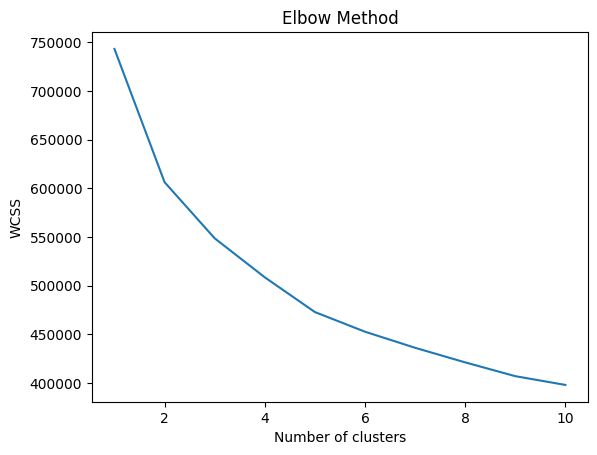

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the features
X = df_elbow.drop('user_id', axis=1)  # Assuming 'user_id' is not a feature

wcss = []
for i in range(1, 11):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS for the model

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


### Transfer table back to bigquery

In [ ]:
# Iterate through columns and convert uint8 to int
for col in df.columns:
    if df[col].dtype == 'uint8':
        df[col] = df[col].astype(int)

# Check the updated DataFrame info
#df.info()


In [25]:
from pandas_gbq import to_gbq

# Define the table ID where you want to save the DataFrame
table_id = 'thelook-product-recom-1.theLook.customer_features_preprocessed'

# Upload the DataFrame to BigQuery
to_gbq(df, table_id, project_id='thelook-product-recom-1', if_exists='replace')


100%|██████████| 1/1 [00:00<00:00, 6123.07it/s]
